# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [2]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [4]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 5. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [7]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=500,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

epoch: 0  train_loss: 19.971622467041016
epoch: 1  train_loss: 19.9715518951416
epoch: 2  train_loss: 19.971487045288086
epoch: 3  train_loss: 19.971420288085938
epoch: 4  train_loss: 19.971351623535156
epoch: 5  train_loss: 19.97128677368164
epoch: 6  train_loss: 19.97121810913086
epoch: 7  train_loss: 19.971153259277344
epoch: 8  train_loss: 19.971086502075195
epoch: 9  train_loss: 19.97102165222168
epoch: 10  train_loss: 19.970958709716797
epoch: 11  train_loss: 19.97089385986328
epoch: 12  train_loss: 19.970829010009766
epoch: 13  train_loss: 19.970767974853516
epoch: 14  train_loss: 19.970703125
epoch: 15  train_loss: 19.970640182495117
epoch: 16  train_loss: 19.970577239990234
epoch: 17  train_loss: 19.97051429748535
epoch: 18  train_loss: 19.970455169677734
epoch: 19  train_loss: 19.97039031982422
epoch: 20  train_loss: 19.97032928466797
epoch: 21  train_loss: 19.97027015686035
epoch: 22  train_loss: 19.9702091217041
epoch: 23  train_loss: 19.97014617919922
epoch: 24  train_loss

epoch: 203  train_loss: 19.961835861206055
epoch: 204  train_loss: 19.96179962158203
epoch: 205  train_loss: 19.961767196655273
epoch: 206  train_loss: 19.961732864379883
epoch: 207  train_loss: 19.961700439453125
epoch: 208  train_loss: 19.9616641998291
epoch: 209  train_loss: 19.96162986755371
epoch: 210  train_loss: 19.961593627929688
epoch: 211  train_loss: 19.961563110351562
epoch: 212  train_loss: 19.961524963378906
epoch: 213  train_loss: 19.961490631103516
epoch: 214  train_loss: 19.961458206176758
epoch: 215  train_loss: 19.961427688598633
epoch: 216  train_loss: 19.96139144897461
epoch: 217  train_loss: 19.96135711669922
epoch: 218  train_loss: 19.96132469177246
epoch: 219  train_loss: 19.96129035949707
epoch: 220  train_loss: 19.961261749267578
epoch: 221  train_loss: 19.961225509643555
epoch: 222  train_loss: 19.96119499206543
epoch: 223  train_loss: 19.961162567138672
epoch: 224  train_loss: 19.961130142211914
epoch: 225  train_loss: 19.961097717285156
epoch: 226  train_lo

epoch: 401  train_loss: 19.956695556640625
epoch: 402  train_loss: 19.956674575805664
epoch: 403  train_loss: 19.956653594970703
epoch: 404  train_loss: 19.956634521484375
epoch: 405  train_loss: 19.956615447998047
epoch: 406  train_loss: 19.956594467163086
epoch: 407  train_loss: 19.956575393676758
epoch: 408  train_loss: 19.95655632019043
epoch: 409  train_loss: 19.956539154052734
epoch: 410  train_loss: 19.956518173217773
epoch: 411  train_loss: 19.956497192382812
epoch: 412  train_loss: 19.956478118896484
epoch: 413  train_loss: 19.956459045410156
epoch: 414  train_loss: 19.95644187927246
epoch: 415  train_loss: 19.9564208984375
epoch: 416  train_loss: 19.956401824951172
epoch: 417  train_loss: 19.956382751464844
epoch: 418  train_loss: 19.956363677978516
epoch: 419  train_loss: 19.956340789794922
epoch: 420  train_loss: 19.95632553100586
epoch: 421  train_loss: 19.9563045501709
epoch: 422  train_loss: 19.956287384033203
epoch: 423  train_loss: 19.956270217895508
epoch: 424  train_

# Evaluate best model on a system rollout of 50 time steps


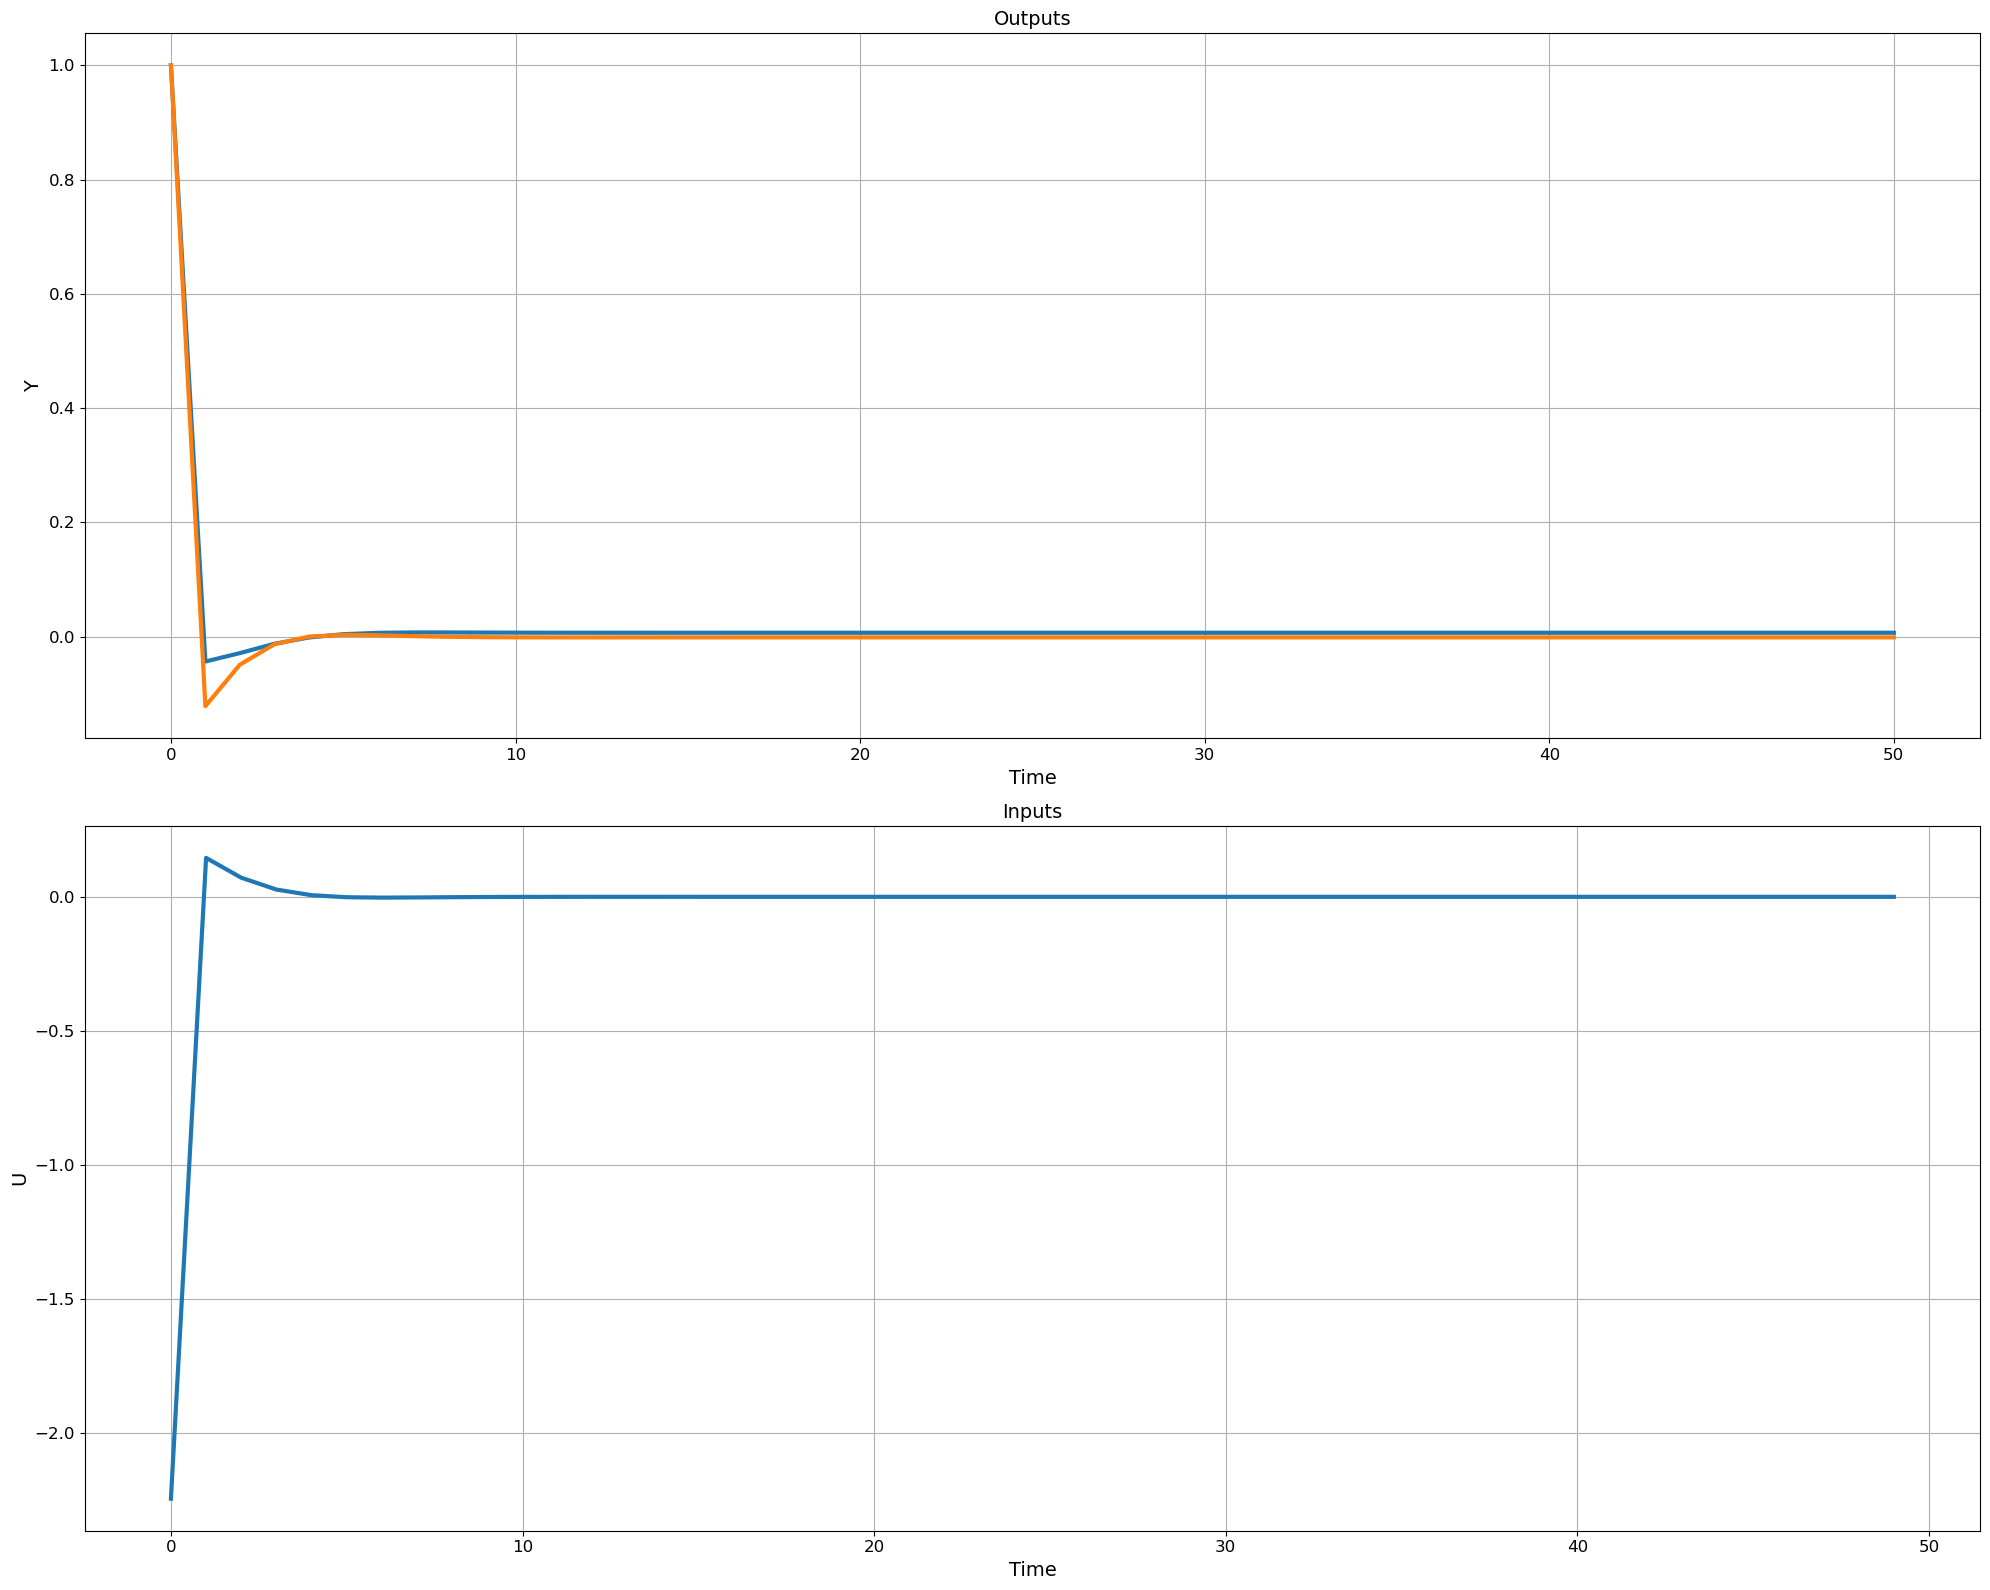

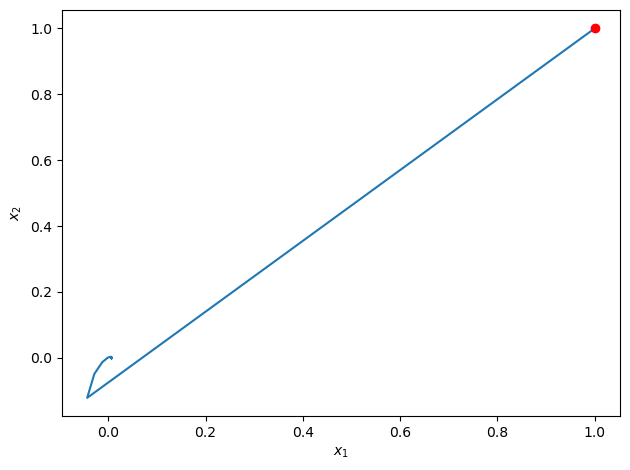

<Figure size 640x480 with 0 Axes>

In [8]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
cl_system.nsteps = 50
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(51, 2), U=trajectories['U'].detach().reshape(50, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(51, 2), figname='phase.png')